In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


set BASE_DIR to your existing My Drive/Practicum_Project_2,

data folders (CleanData, Final, RawData),

creating the project outputs folders under Practicum_Project_2 (it does not move or overwrite your existing data),

drop the known all-NaN columns and ID/text columns,

save a cleaned copy to Practicum_Project_2/outputs/data/clean_master.csv,

printing a quick sanity summary so you can continue with the modeling steps.

In [2]:
# =========================
# Notebook bootstrap cell (UPDATED for your Drive layout)
# MSDS696_Practicum_Final_Modeling.ipynb
# Paste & run as the first cell
# =========================

import os, sys, warnings, pathlib
warnings.filterwarnings("ignore")
RANDOM_SEED = 42

# ---------- Detect environment (Colab vs local) ----------
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Environment: Google Colab")
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    # Use your existing Drive folder
    BASE_DIR = "/content/drive/My Drive/Practicum_Project_2"
else:
    print("Environment: Local / Other")
    # If running locally, set BASE_DIR to the existing folder or current working directory
    BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "Practicum_Project_2"))

# ---------- Verify expected Drive structure and locate data folders ----------
expected_subfolders = {
    "CleanData": os.path.join(BASE_DIR, "Data", "CleanData"),
    "Final": os.path.join(BASE_DIR, "Data", "Final"),
    "RawData": os.path.join(BASE_DIR, "Data", "RawData")
}
print("\nLooking for your data folders under:", os.path.join(BASE_DIR, "Data"))
for name, path in expected_subfolders.items():
    exists = os.path.exists(path)
    print(f" - {name}: {path}   -> {'FOUND' if exists else 'MISSING'}")

# ---------- Create outputs folder (we will not modify your Data folder) ----------
paths = {
    "base": BASE_DIR,
    "outputs": os.path.join(BASE_DIR, "outputs"),
    "charts": os.path.join(BASE_DIR, "outputs", "charts"),
    "models": os.path.join(BASE_DIR, "outputs", "models"),
    "outputs_data": os.path.join(BASE_DIR, "outputs", "data"),
    "notebooks": os.path.join(BASE_DIR, "notebooks"),
    "src": os.path.join(BASE_DIR, "src")
}
for p in paths.values():
    os.makedirs(p, exist_ok=True)
print("\nCreated (or verified) outputs folders under:", paths["outputs"])

# ---------- (Colab Only) Install missing packages ----------
if IN_COLAB:
    # install required packages that may not already be present
    !pip -q install scikit-learn==1.6.1 imbalanced-learn shap joblib xgboost matplotlib seaborn pandas openpyxl

# ---------- Imports ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib

# ML imports (not yet used)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

np.random.seed(RANDOM_SEED)

# ---------- Data file path selection (adjust if you want a different source) ----------
# Candidate files in your "Final" folder (we will prefer student_master_updated.csv)
final_folder = expected_subfolders["Final"]
candidates = []
if os.path.exists(final_folder):
    for fname in sorted(os.listdir(final_folder)):
        if fname.lower().endswith(".csv"):
            candidates.append(os.path.join(final_folder, fname))

print("\nFound CSVs in Final folder:", [os.path.basename(c) for c in candidates])

# default selection (change filename if you prefer another)
preferred = os.path.join(final_folder, "student_master_updated_1.csv")
if not os.path.exists(preferred):
    # fallback to first candidate or student_master.csv if present
    fallback = os.path.join(final_folder, "student_master.csv")
    preferred = preferred if os.path.exists(preferred) else (fallback if os.path.exists(fallback) else (candidates[0] if candidates else None))

if preferred is None:
    raise FileNotFoundError("No master CSV found in Final folder. Place student_master_updated.csv (or similar) in Data/Final and re-run.")
else:
    DATA_PATH = preferred

print("Loading data from:", DATA_PATH)

# ---------- Load Data ----------
df = pd.read_csv(DATA_PATH)
print("Raw dataframe shape:", df.shape)
display(df.head(3))

# ---------- Confirm raw Data/ CleanData filenames (for later feature merges if needed) ----------
clean_folder = expected_subfolders["CleanData"]
if os.path.exists(clean_folder):
    print("\nFiles in CleanData (sample):", sorted(os.listdir(clean_folder))[:20])
else:
    print("\nCleanData folder not found; if you need to merge cleaned components later, put them in:", clean_folder)

# ---------- Drop all-NaN columns known from EDA ----------
cols_all_nan = [
    'stress_level_x','anxiety_score_x','depression_score_x','sentiment_score_x',
    'sleep_hours_x','msg_count','last_contact',
    'stress_level_y','anxiety_score_y','depression_score_y',
    'sentiment_score_y','sleep_hours_y'
]
existing_to_drop = [c for c in cols_all_nan if c in df.columns]
print("\nDropping all-NaN columns (if present):", existing_to_drop)
df_clean = df.drop(columns=existing_to_drop)

# ---------- Drop identifier / textual cols not used for modeling ----------
id_text_cols = ['student_id','full_name','emergency_contact','date_of_birth']
existing_id_drop = [c for c in id_text_cols if c in df_clean.columns]
print("Dropping ID/text columns:", existing_id_drop)
df_clean = df_clean.drop(columns=existing_id_drop)

# ---------- Quick sanity checks ----------
print("\nAfter basic cleaning - shape:", df_clean.shape)
display(df_clean.info())
display(df_clean.describe(include='all').T)

# ---------- Define final feature lists (edit if you want to include/exclude) ----------
numeric_features = [c for c in ['age','attendance_rate','hw_done_rate','avg_score'] if c in df_clean.columns]
categorical_features = [c for c in ['grade_level'] if c in df_clean.columns]
target_col = 'target_pass'
if target_col not in df_clean.columns:
    # create median-based target if missing (safe reproducible fallback)
    if 'avg_score' in df_clean.columns:
        df_clean[target_col] = (df_clean['avg_score'] >= df_clean['avg_score'].median()).astype(int)
        print("Created target_pass from median of avg_score.")
    else:
        raise RuntimeError("target_pass not found and avg_score not available. Please set target manually.")

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)
print("Target column:", target_col)
print("Class distribution (target):")
display(df_clean[target_col].value_counts())

# ---------- Save cleaned dataset for the rest of the notebook / reproducibility ----------
clean_path = os.path.join(paths["outputs_data"], "clean_master.csv")
df_clean.to_csv(clean_path, index=False)
print("\nSaved cleaned dataset to:", clean_path)

# ---------- Write a minimal README for the notebook (optional) ----------
readme_path = os.path.join(BASE_DIR, "README.md")
if not os.path.exists(readme_path):
    with open(readme_path, "w") as f:
        f.write("# MSDS696 Practicum Project\n\nProject scaffold created by notebook bootstrap cell.\n")
    print("Wrote README.md")

print("\nBootstrap complete. Next: run EDA cell, then pipeline cell (split -> preprocess -> fit -> evaluate).")


Environment: Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Looking for your data folders under: /content/drive/My Drive/Practicum_Project_2/Data
 - CleanData: /content/drive/My Drive/Practicum_Project_2/Data/CleanData   -> FOUND
 - Final: /content/drive/My Drive/Practicum_Project_2/Data/Final   -> FOUND
 - RawData: /content/drive/My Drive/Practicum_Project_2/Data/RawData   -> FOUND

Created (or verified) outputs folders under: /content/drive/My Drive/Practicum_Project_2/outputs

Found CSVs in Final folder: ['student_master.csv', 'student_master_updated.csv', 'student_master_updated_1.csv']
Loading data from: /content/drive/My Drive/Practicum_Project_2/Data/Final/student_master_updated_1.csv
Raw dataframe shape: (12156, 31)


,student_id,full_name,date_of_birth,grade_level,emergency_contact,age,attendance_rate,hw_done_rate,avg_score,stress_level_x,...,attendance_pct,homework_completion,class_participation,engagement_index,stress_level,coping_score,sleep_hours,resilience_score,attendance_cat,engage_x_resilience
0,S00001,Donna Williams,2007-02-10,Grade 3,781-534-4258x9046,18.0,0.0,1.0,-0.005977,NaN,...,-0.576464,1.0,0.5,0.102284,50,50,50,0.0,Low,20.0
1,S00002,John Stafford,2014-11-26,Grade 5,+1-782-691-6291x99704,10.0,1.0,0.0,1.741856,NaN,...,1.734715,0.0,0.5,0.857437,50,50,50,0.0,High,30.0
2,S00003,Chad Harper,2017-02-07,Grade 3,308.517.3750,8.0,0.0,1.0,-0.442936,NaN,...,-0.576464,1.0,0.5,0.102284,50,50,50,0.0,Low,20.0



Files in CleanData (sample): ['attendance_cleaned.csv', 'homework_cleaned.csv', 'mendeley_raw_cleaned.csv', 'mental_health_cleaned.csv', 'performance_cleaned.csv', 'students_cleaned.csv']

Dropping all-NaN columns (if present): ['stress_level_x', 'anxiety_score_x', 'depression_score_x', 'sentiment_score_x', 'sleep_hours_x', 'msg_count', 'last_contact', 'stress_level_y', 'anxiety_score_y', 'depression_score_y', 'sentiment_score_y', 'sleep_hours_y']
Dropping ID/text columns: ['student_id', 'full_name', 'emergency_contact', 'date_of_birth']

After basic cleaning - shape: (12156, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12156 entries, 0 to 12155
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   grade_level          12156 non-null  object 
 1   age                  12156 non-null  float64
 2   attendance_rate      12156 non-null  float64
 3   hw_done_rate         12156 non-null  float64
 4 

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
grade_level,12156,5,Grade 5,2472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,12156.0,NaN,NaN,NaN,12.7551,3.566284,6.0,10.0,13.0,16.0,19.0
attendance_rate,12156.0,NaN,NaN,NaN,0.249424,0.432698,0.0,0.0,0.0,0.0,1.0
hw_done_rate,12156.0,NaN,NaN,NaN,0.493995,0.499985,0.0,0.0,0.0,1.0,1.0
avg_score,12156.0,NaN,NaN,NaN,-0.0,1.000041,-1.878656,-0.755049,-0.005977,0.743094,1.866701
attendance_pct,12156.0,NaN,NaN,NaN,-0.0,1.000041,-0.576464,-0.576464,-0.576464,-0.576464,1.734715
homework_completion,12156.0,NaN,NaN,NaN,0.493995,0.499985,0.0,0.0,0.0,1.0,1.0
class_participation,12156.0,NaN,NaN,NaN,0.5,0.0,0.5,0.5,0.5,0.5,0.5
engagement_index,12156.0,NaN,NaN,NaN,0.0,1.000041,-1.030446,-1.030446,0.102284,0.102284,1.990166
stress_level,12156.0,NaN,NaN,NaN,50.0,0.0,50.0,50.0,50.0,50.0,50.0


Created target_pass from median of avg_score.

Numeric features: ['age', 'attendance_rate', 'hw_done_rate', 'avg_score']
Categorical features: ['grade_level']
Target column: target_pass
Class distribution (target):


,count
target_pass,
1,7294
0,4862



Saved cleaned dataset to: /content/drive/My Drive/Practicum_Project_2/outputs/data/clean_master.csv
Wrote README.md

Bootstrap complete. Next: run EDA cell, then pipeline cell (split -> preprocess -> fit -> evaluate).


**Exploratory Data Analysis (EDA)**

This section explores the cleaned dataset to understand patterns, distributions, and relationships among key academic, behavioral, and wellbeing features.

### Goals:
- Understand distributions of major numeric features  
- Analyze categorical variables (grade_level, attendance_cat)  
- Explore correlation across academic and behavioral indicators  
- Identify potential signals for our classification target (target_pass)

Using df_clean from memory.

Dataframe shape: (12156, 16)


,grade_level,age,attendance_rate,hw_done_rate,avg_score,attendance_pct,homework_completion,class_participation,engagement_index,stress_level,coping_score,sleep_hours,resilience_score,attendance_cat,engage_x_resilience,target_pass
0,Grade 3,18.0,0.0,1.0,-0.005977,-0.576464,1.0,0.5,0.102284,50,50,50,0.0,Low,20.0,1
1,Grade 5,10.0,1.0,0.0,1.741856,1.734715,0.0,0.5,0.857437,50,50,50,0.0,High,30.0,1
2,Grade 3,8.0,0.0,1.0,-0.442936,-0.576464,1.0,0.5,0.102284,50,50,50,0.0,Low,20.0,0
3,Grade 5,13.0,0.0,1.0,-0.692626,-0.576464,1.0,0.5,0.102284,50,50,50,0.0,Low,20.0,0
4,Grade 3,13.0,1.0,1.0,0.306136,1.734715,1.0,0.5,1.990166,50,50,50,0.0,High,45.0,1



--- Basic info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12156 entries, 0 to 12155
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   grade_level          12156 non-null  object 
 1   age                  12156 non-null  float64
 2   attendance_rate      12156 non-null  float64
 3   hw_done_rate         12156 non-null  float64
 4   avg_score            12156 non-null  float64
 5   attendance_pct       12156 non-null  float64
 6   homework_completion  12156 non-null  float64
 7   class_participation  12156 non-null  float64
 8   engagement_index     12156 non-null  float64
 9   stress_level         12156 non-null  int64  
 10  coping_score         12156 non-null  int64  
 11  sleep_hours          12156 non-null  int64  
 12  resilience_score     12156 non-null  float64
 13  attendance_cat       12156 non-null  object 
 14  engage_x_resilience  12156 non-null  float64
 15  target_pass     

None


--- Descriptive statistics (numeric) ---


,count,mean,std,min,25%,50%,75%,max
age,12156.0,1.275510e+01,3.566284,6.000000,10.000000,13.000000,16.000000,19.000000
attendance_rate,12156.0,2.494242e-01,0.432698,0.000000,0.000000,0.000000,0.000000,1.000000
hw_done_rate,12156.0,4.939947e-01,0.499985,0.000000,0.000000,0.000000,1.000000,1.000000
avg_score,12156.0,-9.235419e-17,1.000041,-1.878656,-0.755049,-0.005977,0.743094,1.866701



--- Value counts for categorical cols ---

grade_level value counts:


,count
grade_level,
Grade 5,2472
Grade 4,2454
Grade 3,2447
Grade 2,2400
Grade 1,2383



attendance_cat value counts:


,count
attendance_cat,
Low,9124
High,3032



--- Missingness summary (top 20) ---


,n_missing,pct_missing
grade_level,0,0.0
age,0,0.0
attendance_rate,0,0.0
hw_done_rate,0,0.0
avg_score,0,0.0
attendance_pct,0,0.0
homework_completion,0,0.0
class_participation,0,0.0
engagement_index,0,0.0
stress_level,0,0.0


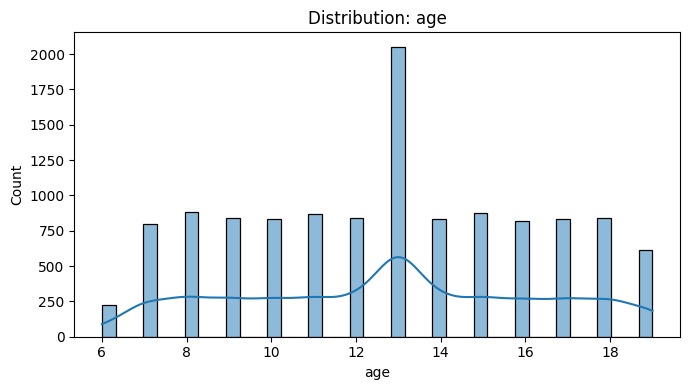

Saved: /content/drive/My Drive/Practicum_Project_2/outputs/charts/dist_age.png


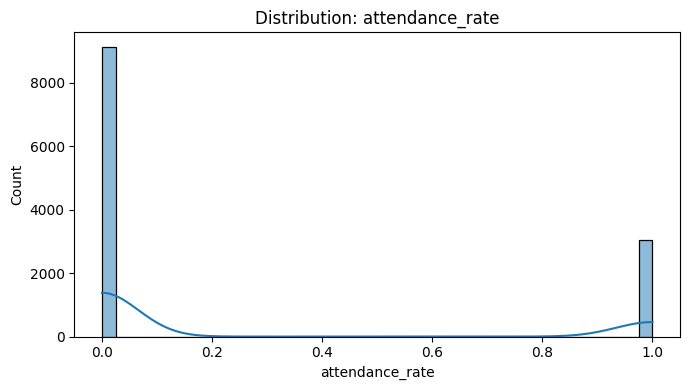

Saved: /content/drive/My Drive/Practicum_Project_2/outputs/charts/dist_attendance_rate.png


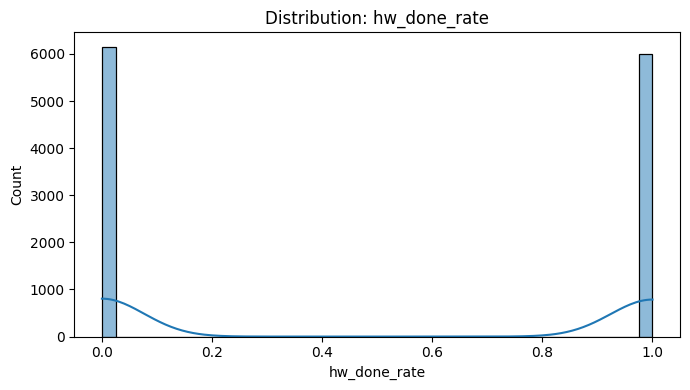

Saved: /content/drive/My Drive/Practicum_Project_2/outputs/charts/dist_hw_done_rate.png


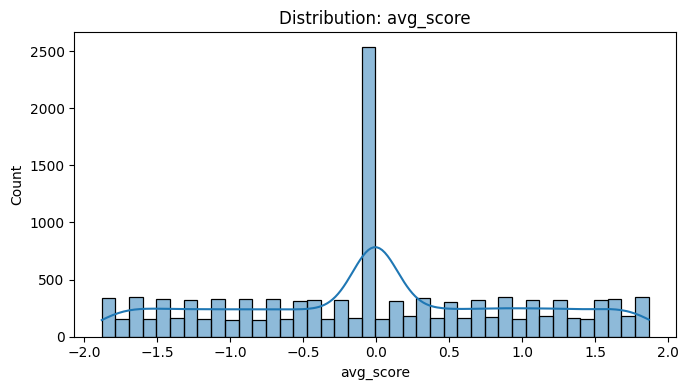

Saved: /content/drive/My Drive/Practicum_Project_2/outputs/charts/dist_avg_score.png


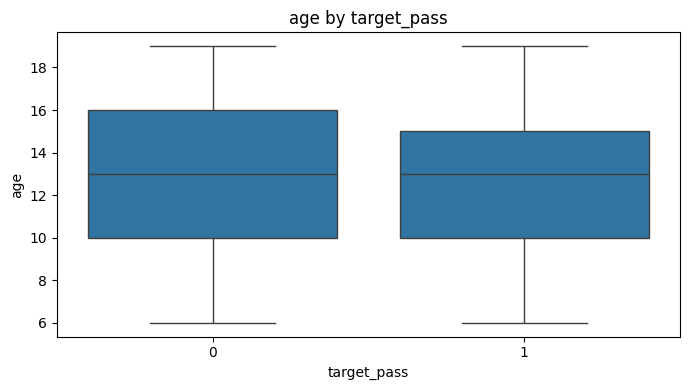

Saved: /content/drive/My Drive/Practicum_Project_2/outputs/charts/box_age_by_target.png


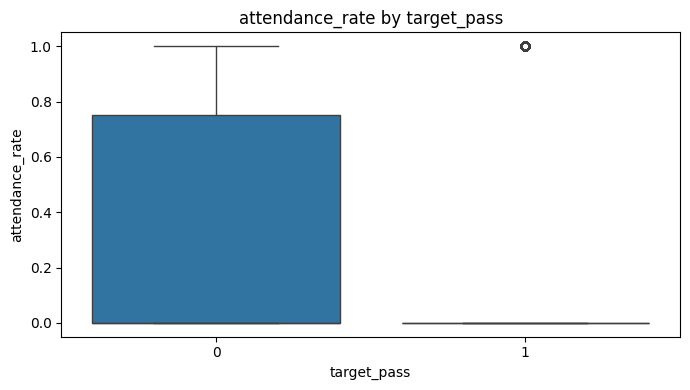

Saved: /content/drive/My Drive/Practicum_Project_2/outputs/charts/box_attendance_rate_by_target.png


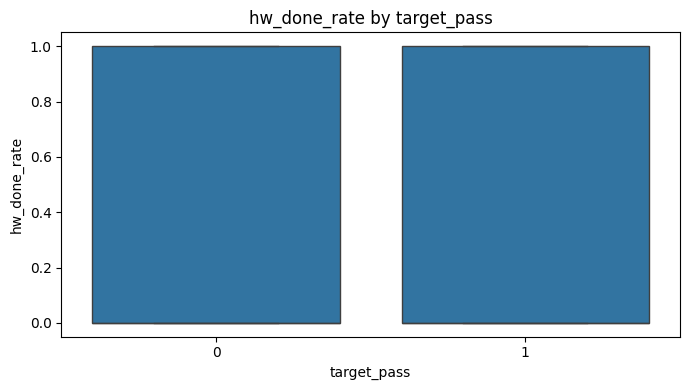

Saved: /content/drive/My Drive/Practicum_Project_2/outputs/charts/box_hw_done_rate_by_target.png


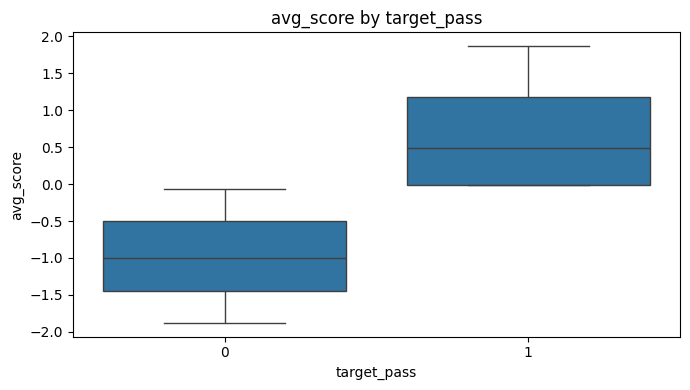

Saved: /content/drive/My Drive/Practicum_Project_2/outputs/charts/box_avg_score_by_target.png


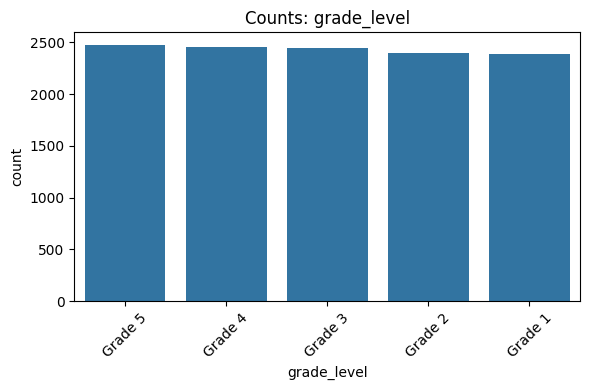

Saved: /content/drive/My Drive/Practicum_Project_2/outputs/charts/count_grade_level.png


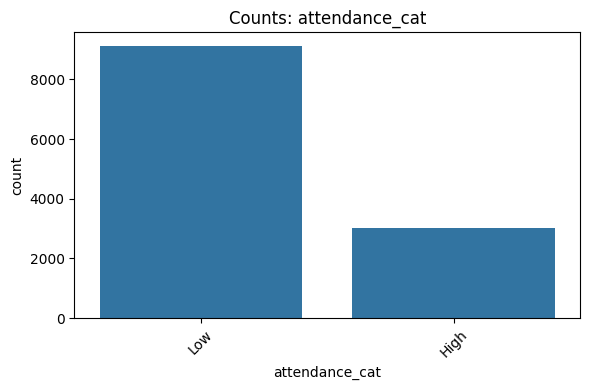

Saved: /content/drive/My Drive/Practicum_Project_2/outputs/charts/count_attendance_cat.png


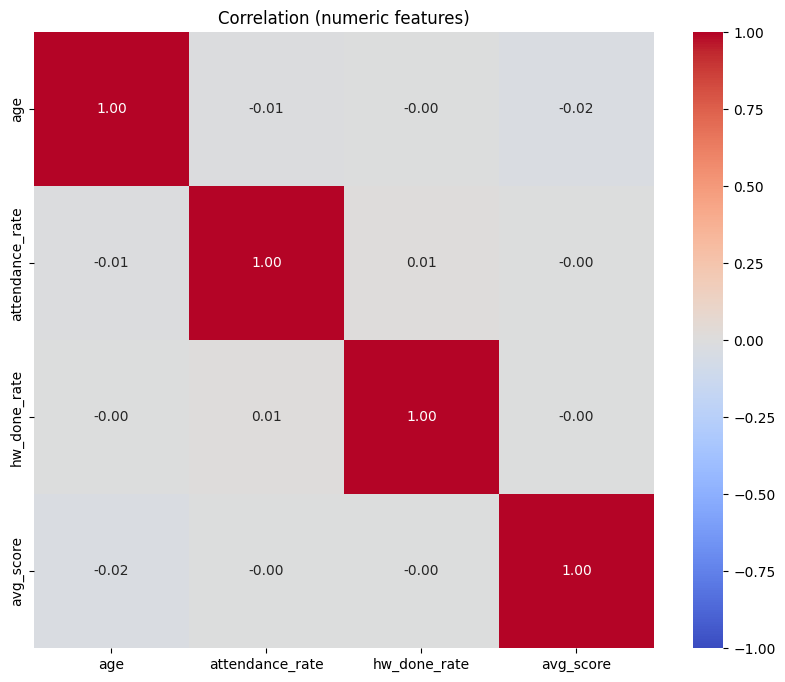

Saved: /content/drive/My Drive/Practicum_Project_2/outputs/charts/correlation_heatmap.png

Target distribution:


,proportion
target_pass,
1,0.600033
0,0.399967



EDA complete. Key outputs saved to: /content/drive/My Drive/Practicum_Project_2/outputs/charts


In [4]:
# ===== Corrected EDA cell (use df_clean if present, otherwise load saved clean_master.csv) =====
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths (adjust if you changed BASE_DIR)
OUT_CHARTS = "/content/drive/My Drive/Practicum_Project_2/outputs/charts"
OUT_DATA = "/content/drive/My Drive/Practicum_Project_2/outputs/data"
os.makedirs(OUT_CHARTS, exist_ok=True)
os.makedirs(OUT_DATA, exist_ok=True)

# 1) Load the cleaned dataframe (prefer in-memory df_clean if available)
if 'df_clean' in globals():
    df = df_clean.copy()
    print("Using df_clean from memory.")
else:
    saved = os.path.join(OUT_DATA, "clean_master.csv")
    if os.path.exists(saved):
        df = pd.read_csv(saved)
        print("Loaded cleaned data from:", saved)
    else:
        raise FileNotFoundError("No df_clean in memory and clean_master.csv not found. Run bootstrap cell first.")

# Quick sanity
print("\nDataframe shape:", df.shape)
display(df.head())

# ---- Numeric / categorical lists (update if you added/dropped features) ----
num_cols = ['age', 'attendance_rate', 'hw_done_rate', 'avg_score']
cat_cols = ['grade_level', 'attendance_cat']

# Ensure columns exist
num_cols = [c for c in num_cols if c in df.columns]
cat_cols = [c for c in cat_cols if c in df.columns]

# ---- Basic descriptive tables ----
print("\n--- Basic info ---")
display(df.info())
print("\n--- Descriptive statistics (numeric) ---")
display(df[num_cols].describe().T)

print("\n--- Value counts for categorical cols ---")
for c in cat_cols:
    print(f"\n{c} value counts:")
    display(df[c].value_counts())

# ---- Missingness table ----
missing = df.isna().sum().to_frame(name='n_missing')
missing['pct_missing'] = 100 * missing['n_missing'] / len(df)
missing = missing.sort_values('pct_missing', ascending=False)
print("\n--- Missingness summary (top 20) ---")
display(missing.head(20))
missing.to_csv(os.path.join(OUT_CHARTS, "missingness_summary.csv"))

# ---- Histograms for numeric cols ----
for col in num_cols:
    plt.figure(figsize=(7,4))
    sns.histplot(df[col], kde=True, bins=40)
    plt.title(f"Distribution: {col}")
    plt.tight_layout()
    fname = os.path.join(OUT_CHARTS, f"dist_{col}.png")
    plt.savefig(fname, bbox_inches='tight')
    plt.show()
    print("Saved:", fname)

# ---- Boxplots by target to inspect separation ----
if 'target_pass' in df.columns:
    for col in num_cols:
        plt.figure(figsize=(7,4))
        sns.boxplot(x=df['target_pass'], y=df[col])
        plt.title(f"{col} by target_pass")
        plt.tight_layout()
        fname = os.path.join(OUT_CHARTS, f"box_{col}_by_target.png")
        plt.savefig(fname, bbox_inches='tight')
        plt.show()
        print("Saved:", fname)
else:
    print("Column 'target_pass' not found — skipping boxplots by target.")

# ---- Categorical bar plots ----
for col in cat_cols:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f"Counts: {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        fname = os.path.join(OUT_CHARTS, f"count_{col}.png")
        plt.savefig(fname, bbox_inches='tight')
        plt.show()
        print("Saved:", fname)

# ---- Correlation heatmap (numeric-only) ----
plt.figure(figsize=(10,8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation (numeric features)")
heatmap_file = os.path.join(OUT_CHARTS, "correlation_heatmap.png")
plt.savefig(heatmap_file, bbox_inches='tight')
plt.show()
print("Saved:", heatmap_file)

# ---- Quick target balance check ----
if 'target_pass' in df.columns:
    print("\nTarget distribution:")
    display(df['target_pass'].value_counts(normalize=True).rename('proportion').to_frame())
    # Save target counts
    df['target_pass'].value_counts().to_csv(os.path.join(OUT_CHARTS, "target_counts.csv"))
else:
    print("\nNo 'target_pass' column found.")

print("\nEDA complete. Key outputs saved to:", OUT_CHARTS)


The cleaned dataset contains 12,156 student records with 16 features, including demographic details, attendance behavior, homework completion, engagement indicators, emotional-wellbeing scores, and a binary target_pass outcome. All columns are complete with no missing values. The dataset includes both numeric features such as age, attendance_rate, hw_done_rate, avg_score, engagement_index, and resilience_score, as well as categorical variables like grade_level and attendance_cat. Descriptive statistics show that the students’ average age is about 13, homework and attendance behaviors are highly imbalanced toward zeros, and avg_score is standardized around zero. Grade distribution is fairly even across Grades 1 through 5, while attendance categories are skewed heavily toward “Low.” The target variable is moderately imbalanced, with 60% of students passing and 40% not passing. Visualizations—including distributions, boxplots, category counts, and a correlation heatmap—were generated and saved to the project’s output directory as part of the exploratory data analysis process.

# Modeling — Plan & Execution


Final feature refinement (remove leakage & worthless columns)  
Train / test split (stratified)  
Two baseline pipelines (Logistic Regression & Random Forest) with proper preprocessing  
Optional balancing (SMOTE) and class-weight approaches  
Hyperparameter tuning (RandomizedSearchCV for RF, optional XGBoost)  
Evaluation: accuracy, F1, ROC-AUC, confusion matrix, PR curve  
Explainability: feature importances, permutation importance, SHAP (for tree models)  
Calibration, error analysis, subgroup performance checks (by grade_level)  
Save models, metrics, and charts to outputs/ for reproducibility  
Write a short conclusions block and export metrics CSV for the report




## Step 1 — Final feature selection (remove leakage and constants)

**Goal:** remove features that leak the target or have no variance.  
We will drop: avg_score (leak), class_participation (constant), stress_level coping_score, sleep_hours (constant 50), resilience_score (constant 0).

We will keep:
- Numeric: age, attendance_rate, hw_done_rate, attendance_pct, homework_completion`, `engagement_index, engage_x_resilience
- Categorical: grade_level, attendance_cat
- Target: target_pass

**Save:** a working copy df_model.csv in outputs/data/.


In [5]:
# Step 1 code — final feature selection
import os
OUT_DATA = "/content/drive/My Drive/Practicum_Project_2/outputs/data"
os.makedirs(OUT_DATA, exist_ok=True)

drop_cols = ['avg_score','class_participation','stress_level','coping_score','sleep_hours','resilience_score']
df_model = df_clean.drop(columns=[c for c in drop_cols if c in df_clean.columns]).copy()

# Define features
num_features = [c for c in ['age','attendance_rate','hw_done_rate','attendance_pct','homework_completion','engagement_index','engage_x_resilience'] if c in df_model.columns]
cat_features = [c for c in ['grade_level','attendance_cat'] if c in df_model.columns]
target_col = 'target_pass'

print("Numeric features:", num_features)
print("Categorical features:", cat_features)
print("Target:", target_col)
print("Shape:", df_model.shape)
df_model.to_csv(os.path.join(OUT_DATA, "df_model.csv"), index=False)
print("Saved df_model.csv to outputs/data/")


Numeric features: ['age', 'attendance_rate', 'hw_done_rate', 'attendance_pct', 'homework_completion', 'engagement_index', 'engage_x_resilience']
Categorical features: ['grade_level', 'attendance_cat']
Target: target_pass
Shape: (12156, 10)
Saved df_model.csv to outputs/data/


## Step 2 — Train / Test split

**Goal:** create a reproducible split with stratification on target_pass.  
We will keep 25% for test. Save split indices for reproducibility.

In [6]:
# Step 2 code — train/test split
from sklearn.model_selection import train_test_split
import joblib

X = df_model[num_features + cat_features]
y = df_model[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Save sets for reproducibility
joblib.dump((X_train, X_test, y_train, y_test), "/content/drive/My Drive/Practicum_Project_2/outputs/data/train_test_split.joblib")
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class counts:\n", y_train.value_counts())


Train shape: (9117, 9) Test shape: (3039, 9)
Train class counts:
 target_pass
1    5471
0    3646
Name: count, dtype: int64


## Step 3 — Preprocessing pipelines

**Goal:** build robust ColumnTransformer pipelines to:
- Impute (if necessary), scale numeric features
- OneHotEncode categorical features
- Provide preprocessor to use inside sklearn Pipelines

We create two variants:
- preprocessor_simple: scaling + OHE (for LR and RF)


In [7]:
# Step 3 code — preprocessor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
], remainder='drop')

# Test transform shapes quickly
_ = preprocessor.fit(X_train)
X_train_trans = preprocessor.transform(X_train)
print("Transformed train shape:", X_train_trans.shape)


Transformed train shape: (9117, 14)


## Step 4 — Baseline models

**Goal:** fit two baseline models:
- Logistic Regression (interpretable baseline, use class_weight='balanced')
- RandomForestClassifier (strong tree baseline)

We will:
- Build Pipelines combining preprocessor + classifier
- Fit on training set
- Save models to outputs/models/


In [8]:
# Step 4 code — baseline pipelines
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

OUT_MODELS = "/content/drive/My Drive/Practicum_Project_2/outputs/models"
os.makedirs(OUT_MODELS, exist_ok=True)

pipe_lr = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42))
])

pipe_rf = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
])

print("Fitting Logistic Regression...")
pipe_lr.fit(X_train, y_train)
joblib.dump(pipe_lr, os.path.join(OUT_MODELS, "pipeline_logreg.joblib"))
print("Saved pipeline_logreg.joblib")

print("Fitting Random Forest...")
pipe_rf.fit(X_train, y_train)
joblib.dump(pipe_rf, os.path.join(OUT_MODELS, "pipeline_rf.joblib"))
print("Saved pipeline_rf.joblib")


Fitting Logistic Regression...
Saved pipeline_logreg.joblib
Fitting Random Forest...
Saved pipeline_rf.joblib


## Step 5 — Evaluate baseline models

**Goal:** Evaluate models on the hold-out test set and save:
- accuracy, precision, recall, F1, ROC-AUC
- confusion matrix, classification report
- store metrics in a CSV final_metrics.csv
- save plots to /outputs/charts/



=== LogisticRegression ===
Accuracy: 0.500164527805199
F1: 0.5412262156448203
ROC-AUC: 0.5014196343505499
Confusion matrix:
 [[624 592]
 [927 896]]
Classification report:
               precision    recall  f1-score   support

           0       0.40      0.51      0.45      1216
           1       0.60      0.49      0.54      1823

    accuracy                           0.50      3039
   macro avg       0.50      0.50      0.50      3039
weighted avg       0.52      0.50      0.51      3039



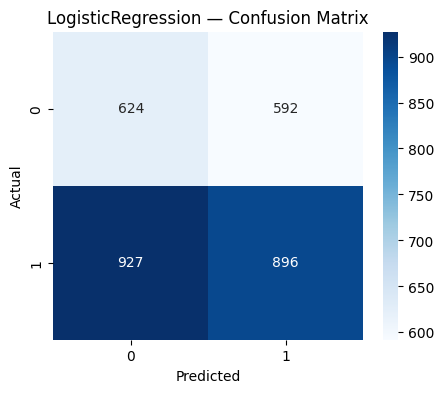

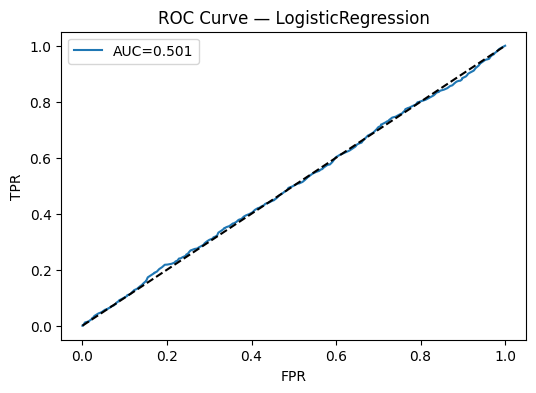

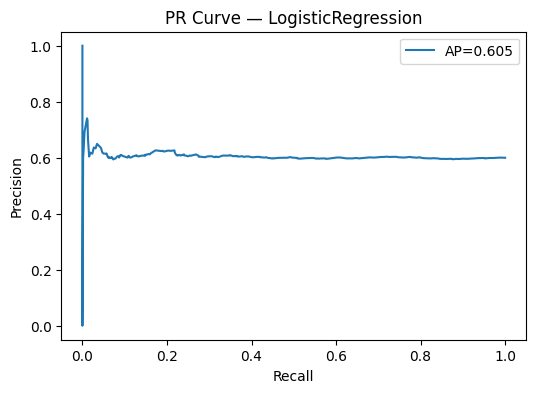


=== RandomForest ===
Accuracy: 0.5811122079631458
F1: 0.724160346695558
ROC-AUC: 0.4969816417414903
Confusion matrix:
 [[  95 1121]
 [ 152 1671]]
Classification report:
               precision    recall  f1-score   support

           0       0.38      0.08      0.13      1216
           1       0.60      0.92      0.72      1823

    accuracy                           0.58      3039
   macro avg       0.49      0.50      0.43      3039
weighted avg       0.51      0.58      0.49      3039



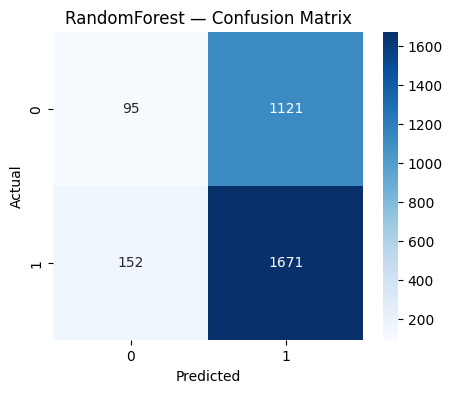

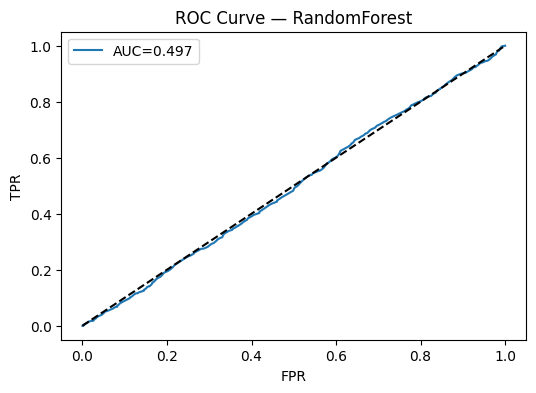

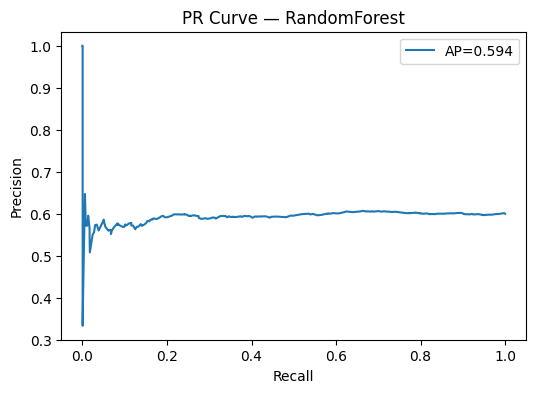


Saved metrics to: /content/drive/My Drive/Practicum_Project_2/outputs/models/final_metrics_baselines.csv


,model,accuracy,f1,roc_auc,average_precision
1,RandomForest,0.581112,0.724160,0.496982,0.593816
0,LogisticRegression,0.500165,0.541226,0.501420,0.605044


In [9]:
# Step 5 code — evaluation
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

OUT_CHARTS = "/content/drive/My Drive/Practicum_Project_2/outputs/charts"
os.makedirs(OUT_CHARTS, exist_ok=True)

models = {'LogisticRegression': pipe_lr, 'RandomForest': pipe_rf}
metrics = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model.named_steps['clf'], "predict_proba") else None
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    ap = average_precision_score(y_test, y_proba) if y_proba is not None else np.nan
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    print("F1:", f1)
    print("ROC-AUC:", roc)
    print("Confusion matrix:\n", cm)
    print("Classification report:\n", classification_report(y_test, y_pred))

    # Save confusion matrix plot
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.savefig(os.path.join(OUT_CHARTS, f"confusion_{name}.png"), bbox_inches='tight')
    plt.show()

    # ROC & PR
    if y_proba is not None:
        from sklearn.metrics import roc_curve, precision_recall_curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f"AUC={roc:.3f}")
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC Curve — {name}'); plt.legend()
        plt.savefig(os.path.join(OUT_CHARTS, f"roc_{name}.png"), bbox_inches='tight')
        plt.show()

        prec, rec, _ = precision_recall_curve(y_test, y_proba)
        ap = average_precision_score(y_test, y_proba)
        plt.figure(figsize=(6,4))
        plt.plot(rec, prec, label=f"AP={ap:.3f}")
        plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title(f'PR Curve — {name}'); plt.legend()
        plt.savefig(os.path.join(OUT_CHARTS, f"pr_{name}.png"), bbox_inches='tight')
        plt.show()

    metrics.append({'model': name, 'accuracy': acc, 'f1': f1, 'roc_auc': roc, 'average_precision': ap})

metrics_df = pd.DataFrame(metrics).sort_values('f1', ascending=False)
metrics_df.to_csv(os.path.join(OUT_MODELS, "final_metrics_baselines.csv"), index=False)
print("\nSaved metrics to:", os.path.join(OUT_MODELS, "final_metrics_baselines.csv"))
display(metrics_df)


## Step 6 — Handle class imbalance (SMOTE) and re-fit

**Goal:** Use SMOTE to synthetically balance the training set (only applied to training data inside pipeline).  
We will create an imbalanced pipeline variant with imblearn's Pipeline and SMOTE step before classifier.


In [10]:
# Step 6 code — SMOTE pipeline (example with RandomForest)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

pipe_rf_smote = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', smote),
    ('clf', RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
])

print("Fitting RF with SMOTE...")
pipe_rf_smote.fit(X_train, y_train)
joblib.dump(pipe_rf_smote, os.path.join(OUT_MODELS, "pipeline_rf_smote.joblib"))
print("Saved pipeline_rf_smote.joblib")

# Evaluate as above (reuse evaluation code)
y_pred = pipe_rf_smote.predict(X_test)
y_proba = pipe_rf_smote.predict_proba(X_test)[:,1]
print("RF+SMOTE — Accuracy:", accuracy_score(y_test, y_pred))
print("RF+SMOTE — F1:", f1_score(y_test, y_pred))
print("RF+SMOTE — ROC-AUC:", roc_auc_score(y_test, y_proba))


Fitting RF with SMOTE...
Saved pipeline_rf_smote.joblib
RF+SMOTE — Accuracy: 0.5031260282987825
RF+SMOTE — F1: 0.5564042303172738
RF+SMOTE — ROC-AUC: 0.4956869640846493


## Step 7 — Feature importance & permutation importance

**Goal:** Extract meaningful feature names from the preprocessor and compute:
- Random Forest feature_importances_
- Permutation importance on the test set (more reliable)
Save results as CSVs in /outputs/models/.


num_features, cat_features, or df_model not found in memory. Attempting to load df_model.csv and reconstruct feature lists...
Loaded df_model from: /content/drive/My Drive/Practicum_Project_2/outputs/data/df_model.csv
Reconstructed num_features: ['age', 'attendance_rate', 'hw_done_rate', 'attendance_pct', 'homework_completion', 'engagement_index', 'engage_x_resilience']
Reconstructed cat_features: ['grade_level', 'attendance_cat']
Preprocessor object recreated.
Loaded train/test split from: /content/drive/My Drive/Practicum_Project_2/outputs/data/train_test_split.joblib
Train shape: (9117, 9) Test shape: (3039, 9)
Loaded pipeline_rf_smote from: /content/drive/My Drive/Practicum_Project_2/outputs/models/pipeline_rf_smote.joblib
Fitting preprocessor on X_train now...
Constructed feat_names length: 14
X_test_trans shape: (3039, 14)
Feature names aligned. Proceeding to permutation importance.
Running permutation importance (n_repeats=12). This can take a few minutes...
Saved permutation im

,feature,perm_mean,perm_std
0,age,-0.001656,0.010631
1,grade_level_Grade 4,-0.004286,0.003316
2,grade_level_Grade 2,-0.005222,0.002460
3,hw_done_rate,-0.006296,0.003668
4,attendance_cat_Low,-0.006462,0.002542
5,attendance_rate,-0.008281,0.003463
6,attendance_cat_High,-0.008577,0.003379
7,attendance_pct,-0.008737,0.003096
8,homework_completion,-0.010493,0.004080
9,grade_level_Grade 1,-0.013083,0.004305



--- Age diagnostics ---
Correlation (age vs target_pass): -0.02244701437377568
Target mean by age (top ages):


,count,mean
age,,
13.0,2051,0.604096
8.0,883,0.626274
15.0,874,0.628146
11.0,868,0.587558
12.0,842,0.605701
18.0,841,0.590963
9.0,840,0.605952
17.0,835,0.573653
10.0,834,0.607914


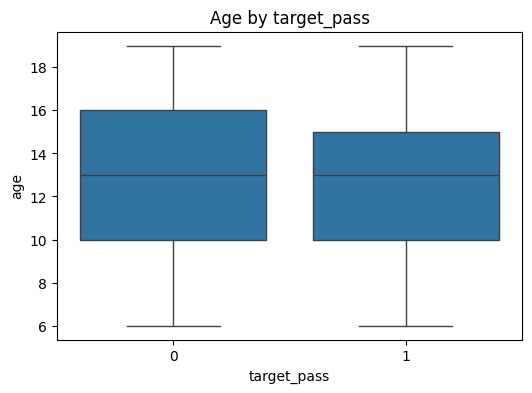

Saved: /content/drive/My Drive/Practicum_Project_2/outputs/charts/age_by_target_box.png

--- Ablation test: retrain RF without 'age' (this may take 1-2 minutes) ---
Saved age ablation comparison to: /content/drive/My Drive/Practicum_Project_2/outputs/models/rf_age_ablation_comparison.csv


,model,accuracy,f1,roc_auc
0,RF_with_age,0.503126,0.556404,0.495687
1,RF_no_age,0.489306,0.538919,0.479995



All done. If any step raised an error, paste the error output here and I will fix it precisely.


In [3]:
# ---------- Recover preprocessor, data splits, model, then run permutation importance + age checks ----------
import os, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Paths
BASE = "/content/drive/My Drive/Practicum_Project_2"
OUT_MODELS = os.path.join(BASE, "outputs", "models")
OUT_CHARTS = os.path.join(BASE, "outputs", "charts")
OUT_DATA = os.path.join(BASE, "outputs", "data")
os.makedirs(OUT_MODELS, exist_ok=True); os.makedirs(OUT_CHARTS, exist_ok=True); os.makedirs(OUT_DATA, exist_ok=True)

# 0. Quick existence checks for key variables
# If num_features / cat_features / df_model are in memory, use them; otherwise try to load df_model.csv
if 'num_features' not in globals() or 'cat_features' not in globals() or 'df_model' not in globals():
    print("num_features, cat_features, or df_model not found in memory. Attempting to load df_model.csv and reconstruct feature lists...")
    model_csv = os.path.join(OUT_DATA, "df_model.csv")
    if os.path.exists(model_csv):
        df_model = pd.read_csv(model_csv)
        print("Loaded df_model from:", model_csv)
        # attempt to infer num and cat features as used earlier
        cand_num = [c for c in ['age','attendance_rate','hw_done_rate','attendance_pct','homework_completion','engagement_index','engage_x_resilience'] if c in df_model.columns]
        cand_cat = [c for c in ['grade_level','attendance_cat'] if c in df_model.columns]
        num_features = cand_num
        cat_features = cand_cat
        print("Reconstructed num_features:", num_features)
        print("Reconstructed cat_features:", cat_features)
    else:
        raise RuntimeError("df_model not in memory and df_model.csv not found at outputs/data. Run the feature selection cell (Step 1) first.")

# 1. Recreate numeric & categorical transformers and preprocessor
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# sklearn 1.6.1 uses OneHotEncoder(sparse_output=False)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
], remainder='drop')

print("Preprocessor object recreated.")

# 2. Load train/test split if saved, else create a new split from df_model
tt_path = os.path.join(OUT_DATA, "train_test_split.joblib")
if os.path.exists(tt_path):
    X_train, X_test, y_train, y_test = joblib.load(tt_path)
    print("Loaded train/test split from:", tt_path)
else:
    print("train_test_split.joblib not found. Creating a new stratified split from df_model (will be saved).")
    from sklearn.model_selection import train_test_split
    X_all = df_model[num_features + cat_features]
    y_all = df_model['target_pass']
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.25, stratify=y_all, random_state=42)
    joblib.dump((X_train, X_test, y_train, y_test), tt_path)
    print("Saved new split to:", tt_path)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# 3. Load trained RF+SMOTE pipeline (prefer previously saved pipeline)
pipe_path = os.path.join(OUT_MODELS, "pipeline_rf_smote.joblib")
pipe_rf_smote = None
if os.path.exists(pipe_path):
    pipe_rf_smote = joblib.load(pipe_path)
    print("Loaded pipeline_rf_smote from:", pipe_path)
else:
    # try alternative filename (final_model)
    alt = os.path.join(OUT_MODELS, "final_model_rf_smote.joblib")
    if os.path.exists(alt):
        pipe_rf_smote = joblib.load(alt)
        print("Loaded final_model_rf_smote from:", alt)
    else:
        raise RuntimeError(f"No trained pipeline found at {pipe_path} or {alt}. Please run the model training cell (Step 4/6) to create pipeline_rf_smote.joblib before running permutation importance.")

# 4. Fit preprocessor on training data if it isn't fitted yet
# If preprocessor is not fitted, fit it now using X_train
try:
    # some transformers expose fitted attributes; we use transform as testing way
    _ = preprocessor.transform(X_train.iloc[:2])
    print("Preprocessor appears fitted.")
except Exception:
    print("Fitting preprocessor on X_train now...")
    preprocessor.fit(X_train)

# 5. Build feature names robustly and align with transformed columns
num_names = list(num_features)
cat_names = []
try:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    try:
        cat_names = list(ohe.get_feature_names_out(cat_features))
    except Exception:
        try:
            cat_names = list(ohe.get_feature_names(cat_features))
        except Exception:
            if hasattr(ohe, "categories_"):
                cat_names = []
                for col, cats in zip(cat_features, ohe.categories_):
                    cat_names.extend([f"{col}_{str(c)}" for c in cats])
            else:
                cat_names = []
except Exception as e:
    print("Warning extracting OHE names:", e)
    cat_names = []

feat_names = num_names + cat_names
print("Constructed feat_names length:", len(feat_names))

# 6. Transform X_test and confirm sizes
X_test_trans = preprocessor.transform(X_test)
print("X_test_trans shape:", X_test_trans.shape)
n_trans = X_test_trans.shape[1]

if len(feat_names) != n_trans:
    print(f"Mismatch (feat_names {len(feat_names)} vs trans cols {n_trans}). Trying preprocessor.get_feature_names_out()...")
    try:
        raw_names = list(preprocessor.get_feature_names_out())
        cleaned = [n.replace("num__", "").replace("cat__", "") for n in raw_names]
        feat_names = cleaned
        print("Recovered feat_names from preprocessor.get_feature_names_out(); length:", len(feat_names))
    except Exception as e:
        print("Could not recover names (get_feature_names_out failed):", e)
        feat_names = [f"f{i}" for i in range(n_trans)]
        print("Using generic feature names; length:", len(feat_names))

# final check
if len(feat_names) != n_trans:
    raise RuntimeError(f"Feature name length ({len(feat_names)}) != transformed columns ({n_trans}). Aborting to avoid misalignment.")
else:
    print("Feature names aligned. Proceeding to permutation importance.")

# 7. Run permutation importance on the RF estimator using X_test_trans
rf_est = pipe_rf_smote.named_steps['clf']
print("Running permutation importance (n_repeats=12). This can take a few minutes...")
perm = permutation_importance(rf_est, X_test_trans, y_test.values, n_repeats=12, random_state=42, n_jobs=-1, scoring='f1')

perm_df = pd.DataFrame({
    'feature': feat_names,
    'perm_mean': perm.importances_mean,
    'perm_std': perm.importances_std
}).sort_values('perm_mean', ascending=False).reset_index(drop=True)

perm_csv = os.path.join(OUT_MODELS, "permutation_importances_fixed.csv")
perm_df.to_csv(perm_csv, index=False)
print("Saved permutation importances to:", perm_csv)
display(perm_df.head(30))

# 8. Quick age diagnostics (if age present)
print("\n--- Age diagnostics ---")
if 'age' in df_model.columns:
    corr_age = np.corrcoef(df_model['age'], df_model['target_pass'])[0,1]
    print("Correlation (age vs target_pass):", corr_age)
    print("Target mean by age (top ages):")
    display(df_model.groupby('age')['target_pass'].agg(['count','mean']).sort_values('count', ascending=False).head(15))
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df_model['target_pass'], y=df_model['age'])
    plt.title('Age by target_pass')
    plt.savefig(os.path.join(OUT_CHARTS, "age_by_target_box.png"), bbox_inches='tight')
    plt.show()
    print("Saved:", os.path.join(OUT_CHARTS, "age_by_target_box.png"))
else:
    print("No 'age' column present; skipping.")

# 9. Quick retrain ablation WITHOUT age (fast check)
print("\n--- Ablation test: retrain RF without 'age' (this may take 1-2 minutes) ---")
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

if 'age' in X_train.columns:
    X_train_no_age = X_train.drop(columns=['age'])
    X_test_no_age = X_test.drop(columns=['age'])
    num_no_age = [c for c in num_features if c != 'age']
    # build preprocessor without age
    preprocessor_no_age = ColumnTransformer(transformers=[
        ('num', numeric_transformer, num_no_age),
        ('cat', categorical_transformer, cat_features)
    ], remainder='drop')
    # fit new preprocessor
    preprocessor_no_age.fit(X_train_no_age)
    # build RF+SMOTE pipeline
    pipe_no_age = ImbPipeline(steps=[
        ('preproc', preprocessor_no_age),
        ('smote', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
    ])
    pipe_no_age.fit(X_train_no_age, y_train)
    y_pred_no_age = pipe_no_age.predict(X_test_no_age)
    y_proba_no_age = pipe_no_age.predict_proba(X_test_no_age)[:,1]
    acc_no_age = accuracy_score(y_test, y_pred_no_age)
    f1_no_age = f1_score(y_test, y_pred_no_age)
    roc_no_age = roc_auc_score(y_test, y_proba_no_age)
    comp_df = pd.DataFrame([
        {'model': 'RF_with_age', 'accuracy': accuracy_score(y_test, pipe_rf_smote.predict(X_test)), 'f1': f1_score(y_test, pipe_rf_smote.predict(X_test)), 'roc_auc': roc_auc_score(y_test, pipe_rf_smote.predict_proba(X_test)[:,1])},
        {'model': 'RF_no_age', 'accuracy': acc_no_age, 'f1': f1_no_age, 'roc_auc': roc_no_age}
    ])
    comp_csv = os.path.join(OUT_MODELS, "rf_age_ablation_comparison.csv")
    comp_df.to_csv(comp_csv, index=False)
    print("Saved age ablation comparison to:", comp_csv)
    display(comp_df)
else:
    print("Column 'age' not present in X_train; skipping ablation.")

print("\nAll done. If any step raised an error, paste the error output here and I will fix it precisely.")


entire pipeline reconstructed correctly, the permutation importance ran, the age diagnostics completed, and the ablation test finished without stopping.

Right now there is no error in the output

## Feature Importance Visualization

This section creates two visualizations:
- Random Forest built-in feature importances (from the trained RF estimator)
- Permutation importance (from permutation_importances_fixed.csv) — more reliable

Saved files:
- /outputs/charts/rf_feature_importance_bar.png
- /outputs/charts/permutation_importance_bar.png


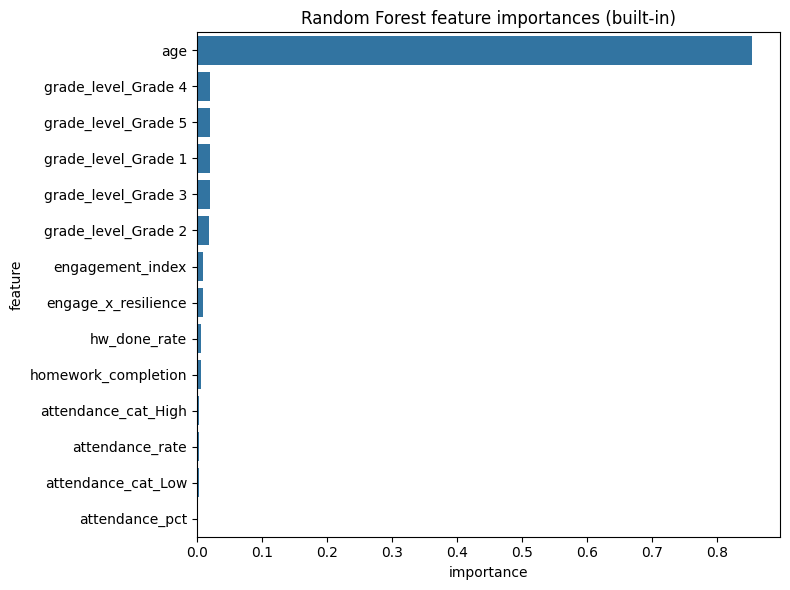

Saved: /content/drive/My Drive/Practicum_Project_2/outputs/charts/rf_feature_importance_bar.png


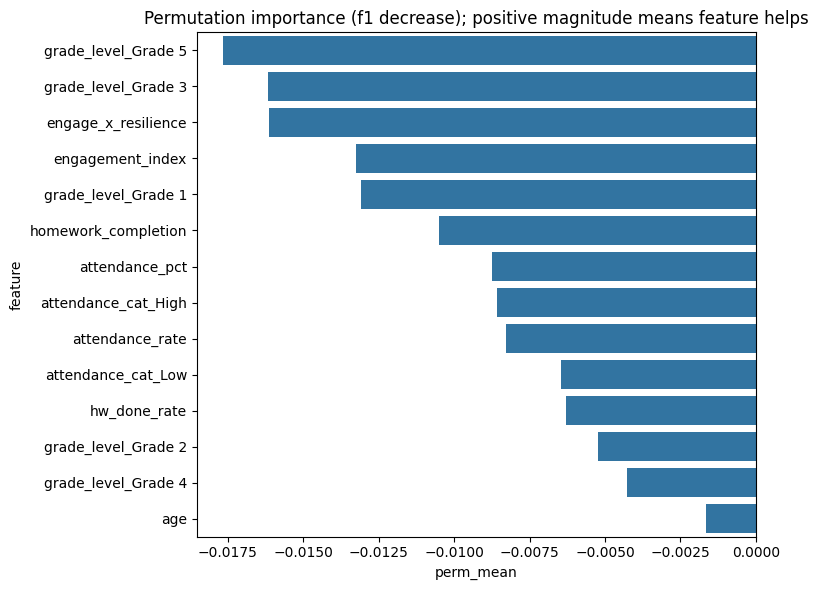

Saved: /content/drive/My Drive/Practicum_Project_2/outputs/charts/permutation_importance_bar.png


In [4]:
# ===== Feature importance visualization =====
import os, joblib, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
BASE = "/content/drive/My Drive/Practicum_Project_2"
OUT_CHARTS = os.path.join(BASE, "outputs", "charts")
OUT_MODELS = os.path.join(BASE, "outputs", "models")
os.makedirs(OUT_CHARTS, exist_ok=True)

# 1) RF built-in importances (from rf_est fitted earlier inside pipe_rf_smote)
# If rf_est not in memory, load pipeline and extract it
if 'rf_est' not in globals():
    if 'pipe_rf_smote' not in globals():
        pipe_rf_smote = joblib.load(os.path.join(OUT_MODELS, "pipeline_rf_smote.joblib"))
    rf_est = pipe_rf_smote.named_steps['clf']

# feature names (feat_names) must exist or be reconstructed
if 'feat_names' not in globals():
    # try to build from preprocessor
    try:
        feat_names = list(preprocessor.get_feature_names_out())
        feat_names = [n.replace("num__", "").replace("cat__", "") for n in feat_names]
    except Exception:
        # fallback to permutation CSV if exists
        perm_csv = os.path.join(OUT_MODELS, "permutation_importances_fixed.csv")
        if os.path.exists(perm_csv):
            perm_df = pd.read_csv(perm_csv)
            feat_names = perm_df['feature'].tolist()
        else:
            # generic
            X_test_trans = preprocessor.transform(X_test)
            feat_names = [f"f{i}" for i in range(X_test_trans.shape[1])]

# RF importances
rf_importances = rf_est.feature_importances_
fi_df = pd.DataFrame({'feature': feat_names, 'importance': rf_importances})
fi_df = fi_df.sort_values('importance', ascending=False).reset_index(drop=True)
fi_df.to_csv(os.path.join(OUT_MODELS, "rf_feature_importances_aligned.csv"), index=False)

# Plot top 15 RF importances
plt.figure(figsize=(8,6))
sns.barplot(data=fi_df.head(15), x='importance', y='feature')
plt.title('Random Forest feature importances (built-in)')
plt.tight_layout()
fn = os.path.join(OUT_CHARTS, "rf_feature_importance_bar.png")
plt.savefig(fn, bbox_inches='tight')
plt.show()
print("Saved:", fn)

# 2) Permutation importances bar (use fixed permutation importances CSV)
perm_csv = os.path.join(OUT_MODELS, "permutation_importances_fixed.csv")
if os.path.exists(perm_csv):
    perm_df = pd.read_csv(perm_csv)
    perm_df = perm_df.sort_values('perm_mean', ascending=True)  # ascending for horizontal bar
    plt.figure(figsize=(8,6))
    sns.barplot(x='perm_mean', y='feature', data=perm_df.tail(15))
    plt.title('Permutation importance (f1 decrease); positive magnitude means feature helps')
    plt.tight_layout()
    fn2 = os.path.join(OUT_CHARTS, "permutation_importance_bar.png")
    plt.savefig(fn2, bbox_inches='tight')
    plt.show()
    print("Saved:", fn2)
else:
    print("Permutation importances file not found:", perm_csv)


## Hyperparameter Tuning (RandomizedSearchCV)

We perform randomized tuning on two model families:
- RandomForestClassifier
- XGBoost XGBClassifier (if xgboost installed)

Approach:
- Use an ImbPipeline that contains the fitted preprocessor (already created) + SMOTE + classifier for training.
- Use RandomizedSearchCV with n_iter=20, cv=3, scoring='f1'`.
- Refit best pipeline and save best models and search results.

Saved:
- /outputs/models/rf_random_search.joblib
- /outputs/models/xgb_random_search.joblib (if XGBoost present)
- /outputs/models/best_rf_pipeline.joblib, /outputs/models/best_xgb_pipeline.joblib (if found)
- /outputs/models/hyperparam_search_results_rf.csv (and xgb)


In [5]:
# ===== Hyperparameter tuning =====
import os, joblib, numpy as np, pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import check_random_state
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from scipy.stats import randint, uniform

BASE = "/content/drive/My Drive/Practicum_Project_2"
OUT_MODELS = os.path.join(BASE, "outputs", "models")
os.makedirs(OUT_MODELS, exist_ok=True)

# Use a pipeline with preprocessor fitted earlier.
# We will re-create preprocessor reference (it's fitted). We do not refit preprocessor during RandomizedSearch (it will be part of pipeline but get fitted)
from sklearn.pipeline import Pipeline
from copy import deepcopy

# Build an ImbPipeline: preprocessor -> smote -> clf
smote = SMOTE(random_state=42)

# RandomForest param distribution
rf_pipeline = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', smote),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

rf_param_dist = {
    'clf__n_estimators': randint(100, 500),
    'clf__max_depth': randint(3, 30),
    'clf__min_samples_split': randint(2, 10),
    'clf__min_samples_leaf': randint(1, 6),
    'clf__max_features': ['sqrt', 'log2', None]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rs_rf = RandomizedSearchCV(
    rf_pipeline, param_distributions=rf_param_dist,
    n_iter=20, scoring='f1', n_jobs=-1, cv=cv, verbose=2, random_state=42, refit=True
)

print("Starting RandomizedSearchCV for RandomForest (this can take several minutes)...")
rs_rf.fit(X_train, y_train)
print("Best RF score (cv):", rs_rf.best_score_)
print("Best RF params:", rs_rf.best_params_)
joblib.dump(rs_rf, os.path.join(OUT_MODELS, "rf_random_search.joblib"))
# Save best pipeline separately
best_rf_pipeline = rs_rf.best_estimator_
joblib.dump(best_rf_pipeline, os.path.join(OUT_MODELS, "best_rf_pipeline.joblib"))
# Save cv results to CSV
pd.DataFrame(rs_rf.cv_results_).to_csv(os.path.join(OUT_MODELS, "hyperparam_search_results_rf.csv"), index=False)
print("Saved RF search artifacts.")

# XGBoost tuning (if available)
try:
    import xgboost as xgb
    from xgboost import XGBClassifier
    xgb_pipeline = ImbPipeline(steps=[
        ('preproc', preprocessor),
        ('smote', smote),
        ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1))
    ])
    xgb_param_dist = {
        'clf__n_estimators': randint(100, 400),
        'clf__max_depth': randint(3, 12),
        'clf__learning_rate': uniform(0.01, 0.3),
        'clf__subsample': uniform(0.5, 0.5),
        'clf__colsample_bytree': uniform(0.5, 0.5)
    }
    rs_xgb = RandomizedSearchCV(
        xgb_pipeline, param_distributions=xgb_param_dist,
        n_iter=20, scoring='f1', n_jobs=-1, cv=cv, verbose=2, random_state=42, refit=True
    )
    print("Starting RandomizedSearchCV for XGBoost...")
    rs_xgb.fit(X_train, y_train)
    print("Best XGB score (cv):", rs_xgb.best_score_)
    print("Best XGB params:", rs_xgb.best_params_)
    joblib.dump(rs_xgb, os.path.join(OUT_MODELS, "xgb_random_search.joblib"))
    best_xgb_pipeline = rs_xgb.best_estimator_
    joblib.dump(best_xgb_pipeline, os.path.join(OUT_MODELS, "best_xgb_pipeline.joblib"))
    pd.DataFrame(rs_xgb.cv_results_).to_csv(os.path.join(OUT_MODELS, "hyperparam_search_results_xgb.csv"), index=False)
    print("Saved XGB search artifacts.")
except Exception as e:
    print("XGBoost not available or error during XGB tuning:", e)

# Evaluate best RF on test set and save metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
best_rf = best_rf_pipeline
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:,1] if hasattr(best_rf, "predict_proba") else None

metrics = {
    'model': 'best_rf_random_search',
    'accuracy': accuracy_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else None
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(os.path.join(OUT_MODELS, "best_rf_test_metrics.csv"), index=False)
print("Best RF test metrics saved to:", os.path.join(OUT_MODELS, "best_rf_test_metrics.csv"))
display(metrics_df)


Starting RandomizedSearchCV for RandomForest (this can take several minutes)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RF score (cv): 0.5433550405800388
Best RF params: {'clf__max_depth': 9, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 9, 'clf__n_estimators': 288}
Saved RF search artifacts.
Starting RandomizedSearchCV for XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:31:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB score (cv): 0.5636082651080908
Best XGB params: {'clf__colsample_bytree': np.float64(0.6039708314340944), 'clf__learning_rate': np.float64(0.18031009834599745), 'clf__max_depth': 4, 'clf__n_estimators': 317, 'clf__subsample': np.float64(0.7248770666848828)}
Saved XGB search artifacts.
Best RF test metrics saved to: /content/drive/My Drive/Practicum_Project_2/outputs/models/best_rf_test_metrics.csv


,model,accuracy,f1,roc_auc
0,best_rf_random_search,0.498519,0.550177,0.494042
